In [2]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
from google.colab import drive

os.chdir('/content/drive/MyDrive/tsum_24_2')
print("Updated Working Directory:", os.getcwd())

Updated Working Directory: /content/drive/MyDrive/tsum_24_2


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# Swish Activation
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)

    def forward(self, x):
        scale = F.adaptive_avg_pool2d(x, 1)
        scale = F.relu(self.fc1(scale))
        scale = torch.sigmoid(self.fc2(scale))
        return x * scale

# MBConv Block
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, kernel_size, stride, reduction=4):
        super(MBConv, self).__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_residual = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(Swish())

        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            Swish(),
            SEBlock(hidden_dim, reduction),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ])

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_residual:
            return x + self.block(x)
        else:
            return self.block(x)

# EfficientNet
class EfficientNet(nn.Module):
    def __init__(self, num_classes=1, width_coeff=1.0, depth_coeff=1.0, dropout_rate=0.1):
        super(EfficientNet, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, int(32 * width_coeff), kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(int(32 * width_coeff)),
            Swish()
        )

        # Configuration: (in_channels, out_channels, expand_ratio, kernel_size, stride, num_blocks)
        settings = [
            (32, 16, 1, 3, 1, 1),
            (16, 24, 6, 3, 2, 2),
            (24, 40, 6, 5, 2, 2),
            (40, 80, 6, 3, 2, 3),
            (80, 112, 6, 5, 1, 3),
            (112, 192, 6, 5, 2, 4),
            (192, 320, 6, 3, 1, 1)
        ]

        self.blocks = self._make_blocks(settings, width_coeff, depth_coeff)

        self.head = nn.Sequential(
            nn.Conv2d(int(320 * width_coeff), int(1280 * width_coeff), kernel_size=1, bias=False),
            nn.BatchNorm2d(int(1280 * width_coeff)),
            Swish(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(int(1280 * width_coeff), num_classes),
            nn.Sigmoid()  # Add Sigmoid for binary classification
        )

    def _make_blocks(self, settings, width_coeff, depth_coeff):
        blocks = []
        for in_channels, out_channels, expand_ratio, kernel_size, stride, num_blocks in settings:
            in_channels = int(in_channels * width_coeff)
            out_channels = int(out_channels * width_coeff)
            num_blocks = int(num_blocks * depth_coeff)

            for i in range(num_blocks):
                blocks.append(MBConv(
                    in_channels=in_channels if i == 0 else out_channels,
                    out_channels=out_channels,
                    expand_ratio=expand_ratio,
                    kernel_size=kernel_size,
                    stride=stride if i == 0 else 1
                ))

        return nn.Sequential(*blocks)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def efficientnet_b0(hidden_layers, hidden_nodes):
    return EfficientNet(width_coeff=1.0, depth_coeff=1.0)

# Training and evaluation function
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, num_epochs):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    train_aucs, test_aucs = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        all_train_labels = []
        all_train_preds = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            images, labels = images.to(device), labels.to(device).float()

            # Forward pass
            outputs = model(images).squeeze()

            # Compute loss
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(outputs.detach().cpu().numpy())

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = accuracy_score(all_train_labels, (np.array(all_train_preds) > 0.5).astype(int))
        train_auc = roc_auc_score(all_train_labels, all_train_preds)
        train_accuracies.append(train_accuracy)
        train_aucs.append(train_auc)

        print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, AUC: {train_auc:.4f}")

        # Testing phase
        model.eval()
        test_loss = 0
        all_test_labels = []
        all_test_preds = []

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Testing]"):
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images).squeeze()

                loss = criterion(outputs, labels)
                test_loss += loss.item()
                all_test_labels.extend(labels.cpu().numpy())
                all_test_preds.extend(outputs.detach().cpu().numpy())

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracy = accuracy_score(all_test_labels, (np.array(all_test_preds) > 0.5).astype(int))
        test_auc = roc_auc_score(all_test_labels, all_test_preds)
        test_accuracies.append(test_accuracy)
        test_aucs.append(test_auc)

        print(f"Epoch [{epoch+1}/{num_epochs}] Testing Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.4f}, AUC: {test_auc:.4f}")

    print("Training and evaluation complete!")
    return test_aucs

In [25]:
class BeanDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        for label, subdir in enumerate(['defect_bean', 'normal_bean']):
            folder = os.path.join(root_dir, subdir)
            for img_name in os.listdir(folder):
                img_path = os.path.join(folder, img_name)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = BeanDataset(root_dir="./bean_img", transform=transform)
train_data, test_data = train_test_split(dataset.data, test_size=0.2, random_state=42)

class SplitDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = SplitDataset(train_data, transform=transform)
test_dataset = SplitDataset(test_data, transform=transform)


In [ ]:
from itertools import product

def grid_search(hyperparams, model_fn, train_dataset, test_dataset, device, num_epochs=5):
    best_params = None
    best_auc = 0
    best_model = None  # 최적 모델을 저장할 변수
    results = []

    for lr, batch_size, hidden_layers, hidden_nodes in product(
        hyperparams['lr'], hyperparams['batch_size'], hyperparams['hidden_layers'], hyperparams['hidden_nodes']
    ):
        print(f"Testing combination: LR={lr}, Batch Size={batch_size}, Hidden Layers={hidden_layers}, Hidden Nodes={hidden_nodes}")
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # 모델 초기화
        model = model_fn(hidden_layers, hidden_nodes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.BCELoss()

        # 모델 학습 및 평가
        test_aucs = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, num_epochs)
        test_auc = test_aucs[-1]  # 마지막 AUC 값 사용

        # 결과 저장
        results.append((lr, batch_size, hidden_layers, hidden_nodes, test_auc))
        if test_auc > best_auc:
            best_auc = test_auc
            best_params = (lr, batch_size, hidden_layers, hidden_nodes)
            best_model = model  # 최적 모델 업데이트

    print("Best Parameters:", best_params)
    return best_params, best_model, results


# Hyperparameters to test
hyperparams = {
    'lr': [0.001, 0.0005],
    'batch_size': [32, 64],
    'hidden_layers': [1, 2],
    'hidden_nodes': [128, 256]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_params, best_model, results = grid_search(hyperparams, efficientnet_b0, train_dataset, test_dataset, device)

# 최적 모델 구조 출력
print("Best Model Structure:")
print(best_model)

Testing combination: LR=0.001, Batch Size=32, Hidden Layers=1, Hidden Nodes=128


Epoch 1/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.36it/s]


Epoch [1/5] Training Loss: 0.5962, Accuracy: 0.6733, AUC: 0.7422


Epoch 1/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.40it/s]


Epoch [1/5] Testing Loss: 0.6039, Accuracy: 0.6593, AUC: 0.8129


Epoch 2/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.35it/s]


Epoch [2/5] Training Loss: 0.4235, Accuracy: 0.8150, AUC: 0.8885


Epoch 2/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.36it/s]


Epoch [2/5] Testing Loss: 0.3576, Accuracy: 0.8444, AUC: 0.9241


Epoch 3/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.35it/s]


Epoch [3/5] Training Loss: 0.3084, Accuracy: 0.8641, AUC: 0.9412


Epoch 3/5 [Testing]: 100%|██████████| 26/26 [00:08<00:00,  3.21it/s]


Epoch [3/5] Testing Loss: 0.3879, Accuracy: 0.8531, AUC: 0.9404


Epoch 4/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.36it/s]


Epoch [4/5] Training Loss: 0.2207, Accuracy: 0.9049, AUC: 0.9704


Epoch 4/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.35it/s]


Epoch [4/5] Testing Loss: 0.4114, Accuracy: 0.8494, AUC: 0.9319


Epoch 5/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.34it/s]


Epoch [5/5] Training Loss: 0.2053, Accuracy: 0.9132, AUC: 0.9742


Epoch 5/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.41it/s]


Epoch [5/5] Testing Loss: 0.4354, Accuracy: 0.8481, AUC: 0.9407
Training and evaluation complete!
Testing combination: LR=0.001, Batch Size=32, Hidden Layers=1, Hidden Nodes=256


Epoch 1/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.36it/s]


Epoch [1/5] Training Loss: 0.6488, Accuracy: 0.6140, AUC: 0.6794


Epoch 1/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.30it/s]


Epoch [1/5] Testing Loss: 1.2557, Accuracy: 0.5370, AUC: 0.7713


Epoch 2/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.36it/s]


Epoch [2/5] Training Loss: 0.4550, Accuracy: 0.7897, AUC: 0.8674


Epoch 2/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.26it/s]


Epoch [2/5] Testing Loss: 2.1339, Accuracy: 0.5333, AUC: 0.7991


Epoch 3/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.34it/s]


Epoch [3/5] Training Loss: 0.3414, Accuracy: 0.8607, AUC: 0.9271


Epoch 3/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.44it/s]


Epoch [3/5] Testing Loss: 1.7510, Accuracy: 0.5432, AUC: 0.9343


Epoch 4/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.35it/s]


Epoch [4/5] Training Loss: 0.2513, Accuracy: 0.8944, AUC: 0.9607


Epoch 4/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.32it/s]


Epoch [4/5] Testing Loss: 0.3448, Accuracy: 0.8667, AUC: 0.9496


Epoch 5/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.35it/s]


Epoch [5/5] Training Loss: 0.2097, Accuracy: 0.9129, AUC: 0.9734


Epoch 5/5 [Testing]: 100%|██████████| 26/26 [00:08<00:00,  3.15it/s]


Epoch [5/5] Testing Loss: 0.3199, Accuracy: 0.8716, AUC: 0.9475
Training and evaluation complete!
Testing combination: LR=0.001, Batch Size=32, Hidden Layers=2, Hidden Nodes=128


Epoch 1/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.33it/s]


Epoch [1/5] Training Loss: 0.6232, Accuracy: 0.6495, AUC: 0.7080


Epoch 1/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.30it/s]


Epoch [1/5] Testing Loss: 3.0585, Accuracy: 0.5728, AUC: 0.7084


Epoch 2/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.34it/s]


Epoch [2/5] Training Loss: 0.4297, Accuracy: 0.7986, AUC: 0.8858


Epoch 2/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.39it/s]


Epoch [2/5] Testing Loss: 2.5492, Accuracy: 0.5309, AUC: 0.8459


Epoch 3/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.33it/s]


Epoch [3/5] Training Loss: 0.3262, Accuracy: 0.8598, AUC: 0.9353


Epoch 3/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.25it/s]


Epoch [3/5] Testing Loss: 0.5599, Accuracy: 0.7753, AUC: 0.8608


Epoch 4/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.36it/s]


Epoch [4/5] Training Loss: 0.2529, Accuracy: 0.8941, AUC: 0.9613


Epoch 4/5 [Testing]: 100%|██████████| 26/26 [00:08<00:00,  3.25it/s]


Epoch [4/5] Testing Loss: 0.3235, Accuracy: 0.8506, AUC: 0.9597


Epoch 5/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.32it/s]


Epoch [5/5] Training Loss: 0.1968, Accuracy: 0.9179, AUC: 0.9774


Epoch 5/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.46it/s]


Epoch [5/5] Testing Loss: 0.6850, Accuracy: 0.7457, AUC: 0.9316
Training and evaluation complete!
Testing combination: LR=0.001, Batch Size=32, Hidden Layers=2, Hidden Nodes=256


Epoch 1/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.35it/s]


Epoch [1/5] Training Loss: 0.6535, Accuracy: 0.6115, AUC: 0.6664


Epoch 1/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.32it/s]


Epoch [1/5] Testing Loss: 2.6074, Accuracy: 0.5802, AUC: 0.7225


Epoch 2/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.34it/s]


Epoch [2/5] Training Loss: 0.4256, Accuracy: 0.8135, AUC: 0.8855


Epoch 2/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.26it/s]


Epoch [2/5] Testing Loss: 0.7656, Accuracy: 0.7086, AUC: 0.9338


Epoch 3/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.35it/s]


Epoch [3/5] Training Loss: 0.3254, Accuracy: 0.8595, AUC: 0.9347


Epoch 3/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.32it/s]


Epoch [3/5] Testing Loss: 2.2911, Accuracy: 0.5383, AUC: 0.8701


Epoch 4/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.33it/s]


Epoch [4/5] Training Loss: 0.2673, Accuracy: 0.8897, AUC: 0.9572


Epoch 4/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.41it/s]


Epoch [4/5] Testing Loss: 0.3414, Accuracy: 0.8630, AUC: 0.9325


Epoch 5/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.35it/s]


Epoch [5/5] Training Loss: 0.2195, Accuracy: 0.9104, AUC: 0.9728


Epoch 5/5 [Testing]: 100%|██████████| 26/26 [00:08<00:00,  3.25it/s]


Epoch [5/5] Testing Loss: 0.3736, Accuracy: 0.8272, AUC: 0.9326
Training and evaluation complete!
Testing combination: LR=0.001, Batch Size=64, Hidden Layers=1, Hidden Nodes=128


Epoch 1/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Epoch [1/5] Training Loss: 0.6767, Accuracy: 0.5905, AUC: 0.6194


Epoch 1/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch [1/5] Testing Loss: 1.2985, Accuracy: 0.5432, AUC: 0.5866


Epoch 2/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Epoch [2/5] Training Loss: 0.5006, Accuracy: 0.7610, AUC: 0.8397


Epoch 2/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Epoch [2/5] Testing Loss: 2.6277, Accuracy: 0.5321, AUC: 0.7253


Epoch 3/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Epoch [3/5] Training Loss: 0.3198, Accuracy: 0.8620, AUC: 0.9379


Epoch 3/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Epoch [3/5] Testing Loss: 1.0721, Accuracy: 0.6741, AUC: 0.8871


Epoch 4/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Epoch [4/5] Training Loss: 0.1950, Accuracy: 0.9225, AUC: 0.9766


Epoch 4/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch [4/5] Testing Loss: 1.9907, Accuracy: 0.6086, AUC: 0.8792


Epoch 5/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Epoch [5/5] Training Loss: 0.1413, Accuracy: 0.9460, AUC: 0.9876


Epoch 5/5 [Testing]: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Epoch [5/5] Testing Loss: 0.5257, Accuracy: 0.8259, AUC: 0.9175
Training and evaluation complete!
Testing combination: LR=0.001, Batch Size=64, Hidden Layers=1, Hidden Nodes=256


Epoch 1/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch [1/5] Training Loss: 0.6469, Accuracy: 0.6112, AUC: 0.6734


Epoch 1/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


Epoch [1/5] Testing Loss: 0.8265, Accuracy: 0.5691, AUC: 0.8159


Epoch 2/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Epoch [2/5] Training Loss: 0.4265, Accuracy: 0.8079, AUC: 0.8853


Epoch 2/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Epoch [2/5] Testing Loss: 3.5742, Accuracy: 0.5395, AUC: 0.8228


Epoch 3/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Epoch [3/5] Training Loss: 0.2712, Accuracy: 0.8897, AUC: 0.9544


Epoch 3/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch [3/5] Testing Loss: 0.4547, Accuracy: 0.8395, AUC: 0.9188


Epoch 4/5 [Training]: 100%|██████████| 51/51 [00:45<00:00,  1.13it/s]


Epoch [4/5] Training Loss: 0.1813, Accuracy: 0.9277, AUC: 0.9797


Epoch 4/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch [4/5] Testing Loss: 3.3031, Accuracy: 0.5346, AUC: 0.8161


Epoch 5/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Epoch [5/5] Training Loss: 0.1262, Accuracy: 0.9531, AUC: 0.9900


Epoch 5/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


Epoch [5/5] Testing Loss: 0.9026, Accuracy: 0.7617, AUC: 0.9044
Training and evaluation complete!
Testing combination: LR=0.001, Batch Size=64, Hidden Layers=2, Hidden Nodes=128


Epoch 1/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Epoch [1/5] Training Loss: 0.6522, Accuracy: 0.6186, AUC: 0.6719


Epoch 1/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Epoch [1/5] Testing Loss: 1.8215, Accuracy: 0.5679, AUC: 0.6268


Epoch 2/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch [2/5] Training Loss: 0.4338, Accuracy: 0.7986, AUC: 0.8805


Epoch 2/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch [2/5] Testing Loss: 0.7262, Accuracy: 0.7864, AUC: 0.8677


Epoch 3/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch [3/5] Training Loss: 0.2855, Accuracy: 0.8833, AUC: 0.9501


Epoch 3/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Epoch [3/5] Testing Loss: 1.2338, Accuracy: 0.5975, AUC: 0.8951


Epoch 4/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch [4/5] Training Loss: 0.1596, Accuracy: 0.9407, AUC: 0.9838


Epoch 4/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Epoch [4/5] Testing Loss: 1.1827, Accuracy: 0.6716, AUC: 0.8734


Epoch 5/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Epoch [5/5] Training Loss: 0.1089, Accuracy: 0.9568, AUC: 0.9927


Epoch 5/5 [Testing]: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Epoch [5/5] Testing Loss: 3.0301, Accuracy: 0.5642, AUC: 0.8303
Training and evaluation complete!
Testing combination: LR=0.001, Batch Size=64, Hidden Layers=2, Hidden Nodes=256


Epoch 1/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch [1/5] Training Loss: 0.6473, Accuracy: 0.6093, AUC: 0.6682


Epoch 1/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Epoch [1/5] Testing Loss: 1.0728, Accuracy: 0.5123, AUC: 0.4884


Epoch 2/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch [2/5] Training Loss: 0.4438, Accuracy: 0.8027, AUC: 0.8755


Epoch 2/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Epoch [2/5] Testing Loss: 0.6226, Accuracy: 0.7420, AUC: 0.8170


Epoch 3/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Epoch [3/5] Training Loss: 0.3008, Accuracy: 0.8786, AUC: 0.9449


Epoch 3/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Epoch [3/5] Testing Loss: 0.8668, Accuracy: 0.6630, AUC: 0.9021


Epoch 4/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Epoch [4/5] Training Loss: 0.1968, Accuracy: 0.9253, AUC: 0.9758


Epoch 4/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch [4/5] Testing Loss: 0.5562, Accuracy: 0.8062, AUC: 0.9054


Epoch 5/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch [5/5] Training Loss: 0.1391, Accuracy: 0.9503, AUC: 0.9875


Epoch 5/5 [Testing]: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Epoch [5/5] Testing Loss: 1.5073, Accuracy: 0.6679, AUC: 0.8394
Training and evaluation complete!
Testing combination: LR=0.0005, Batch Size=32, Hidden Layers=1, Hidden Nodes=128


Epoch 1/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.33it/s]


Epoch [1/5] Training Loss: 0.6514, Accuracy: 0.6118, AUC: 0.6630


Epoch 1/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.28it/s]


Epoch [1/5] Testing Loss: 0.7621, Accuracy: 0.6802, AUC: 0.7407


Epoch 2/5 [Training]: 100%|██████████| 102/102 [00:44<00:00,  2.31it/s]


Epoch [2/5] Training Loss: 0.4740, Accuracy: 0.7767, AUC: 0.8558


Epoch 2/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.38it/s]


Epoch [2/5] Testing Loss: 0.8509, Accuracy: 0.6741, AUC: 0.7824


Epoch 3/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.35it/s]


Epoch [3/5] Training Loss: 0.3124, Accuracy: 0.8709, AUC: 0.9409


Epoch 3/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.29it/s]


Epoch [3/5] Testing Loss: 1.0210, Accuracy: 0.7185, AUC: 0.8646


Epoch 4/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.35it/s]


Epoch [4/5] Training Loss: 0.2144, Accuracy: 0.9135, AUC: 0.9717


Epoch 4/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.29it/s]


Epoch [4/5] Testing Loss: 0.5014, Accuracy: 0.8099, AUC: 0.8992


Epoch 5/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.36it/s]


Epoch [5/5] Training Loss: 0.1205, Accuracy: 0.9512, AUC: 0.9910


Epoch 5/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.44it/s]


Epoch [5/5] Testing Loss: 0.7057, Accuracy: 0.7630, AUC: 0.8537
Training and evaluation complete!
Testing combination: LR=0.0005, Batch Size=32, Hidden Layers=1, Hidden Nodes=256


Epoch 1/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.35it/s]


Epoch [1/5] Training Loss: 0.6282, Accuracy: 0.6309, AUC: 0.6910


Epoch 1/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.35it/s]


Epoch [1/5] Testing Loss: 1.0718, Accuracy: 0.6037, AUC: 0.7665


Epoch 2/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.34it/s]


Epoch [2/5] Training Loss: 0.4434, Accuracy: 0.7946, AUC: 0.8762


Epoch 2/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.26it/s]


Epoch [2/5] Testing Loss: 0.6275, Accuracy: 0.6790, AUC: 0.8215


Epoch 3/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.35it/s]


Epoch [3/5] Training Loss: 0.2636, Accuracy: 0.8891, AUC: 0.9581


Epoch 3/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.31it/s]


Epoch [3/5] Testing Loss: 0.6488, Accuracy: 0.7667, AUC: 0.8941


Epoch 4/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.34it/s]


Epoch [4/5] Training Loss: 0.1882, Accuracy: 0.9243, AUC: 0.9786


Epoch 4/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.44it/s]


Epoch [4/5] Testing Loss: 0.5268, Accuracy: 0.8185, AUC: 0.9003


Epoch 5/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.37it/s]


Epoch [5/5] Training Loss: 0.1150, Accuracy: 0.9543, AUC: 0.9921


Epoch 5/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.33it/s]


Epoch [5/5] Testing Loss: 0.5434, Accuracy: 0.8062, AUC: 0.8873
Training and evaluation complete!
Testing combination: LR=0.0005, Batch Size=32, Hidden Layers=2, Hidden Nodes=128


Epoch 1/5 [Training]: 100%|██████████| 102/102 [00:42<00:00,  2.38it/s]


Epoch [1/5] Training Loss: 0.6177, Accuracy: 0.6393, AUC: 0.7089


Epoch 1/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.33it/s]


Epoch [1/5] Testing Loss: 1.3526, Accuracy: 0.5765, AUC: 0.8252


Epoch 2/5 [Training]: 100%|██████████| 102/102 [00:42<00:00,  2.37it/s]


Epoch [2/5] Training Loss: 0.3891, Accuracy: 0.8289, AUC: 0.9047


Epoch 2/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.36it/s]


Epoch [2/5] Testing Loss: 0.5701, Accuracy: 0.7642, AUC: 0.8488


Epoch 3/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.35it/s]


Epoch [3/5] Training Loss: 0.2535, Accuracy: 0.8987, AUC: 0.9603


Epoch 3/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.48it/s]


Epoch [3/5] Testing Loss: 0.4816, Accuracy: 0.8222, AUC: 0.8984


Epoch 4/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.37it/s]


Epoch [4/5] Training Loss: 0.1583, Accuracy: 0.9355, AUC: 0.9845


Epoch 4/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.41it/s]


Epoch [4/5] Testing Loss: 0.7866, Accuracy: 0.7519, AUC: 0.9045


Epoch 5/5 [Training]: 100%|██████████| 102/102 [00:42<00:00,  2.38it/s]


Epoch [5/5] Training Loss: 0.1227, Accuracy: 0.9580, AUC: 0.9907


Epoch 5/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.31it/s]


Epoch [5/5] Testing Loss: 0.4676, Accuracy: 0.8247, AUC: 0.9055
Training and evaluation complete!
Testing combination: LR=0.0005, Batch Size=32, Hidden Layers=2, Hidden Nodes=256


Epoch 1/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.36it/s]


Epoch [1/5] Training Loss: 0.6511, Accuracy: 0.6133, AUC: 0.6706


Epoch 1/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.35it/s]


Epoch [1/5] Testing Loss: 0.7135, Accuracy: 0.6321, AUC: 0.7538


Epoch 2/5 [Training]: 100%|██████████| 102/102 [00:42<00:00,  2.38it/s]


Epoch [2/5] Training Loss: 0.4553, Accuracy: 0.7894, AUC: 0.8689


Epoch 2/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.49it/s]


Epoch [2/5] Testing Loss: 0.6298, Accuracy: 0.7358, AUC: 0.8495


Epoch 3/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.37it/s]


Epoch [3/5] Training Loss: 0.2763, Accuracy: 0.8817, AUC: 0.9549


Epoch 3/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.38it/s]


Epoch [3/5] Testing Loss: 1.0129, Accuracy: 0.6543, AUC: 0.8447


Epoch 4/5 [Training]: 100%|██████████| 102/102 [00:43<00:00,  2.37it/s]


Epoch [4/5] Training Loss: 0.1902, Accuracy: 0.9253, AUC: 0.9778


Epoch 4/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.31it/s]


Epoch [4/5] Testing Loss: 1.7758, Accuracy: 0.5691, AUC: 0.8729


Epoch 5/5 [Training]: 100%|██████████| 102/102 [00:42<00:00,  2.38it/s]


Epoch [5/5] Training Loss: 0.1499, Accuracy: 0.9453, AUC: 0.9867


Epoch 5/5 [Testing]: 100%|██████████| 26/26 [00:07<00:00,  3.35it/s]


Epoch [5/5] Testing Loss: 0.5236, Accuracy: 0.7988, AUC: 0.8879
Training and evaluation complete!
Testing combination: LR=0.0005, Batch Size=64, Hidden Layers=1, Hidden Nodes=128


Epoch 1/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Epoch [1/5] Training Loss: 0.6592, Accuracy: 0.6078, AUC: 0.6451


Epoch 1/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Epoch [1/5] Testing Loss: 0.6526, Accuracy: 0.6383, AUC: 0.6936


Epoch 2/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch [2/5] Training Loss: 0.4456, Accuracy: 0.7974, AUC: 0.8741


Epoch 2/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Epoch [2/5] Testing Loss: 0.5528, Accuracy: 0.7333, AUC: 0.8160


Epoch 3/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.14it/s]


Epoch [3/5] Training Loss: 0.2397, Accuracy: 0.8999, AUC: 0.9651


Epoch 3/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch [3/5] Testing Loss: 0.9103, Accuracy: 0.6827, AUC: 0.8073


Epoch 4/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch [4/5] Training Loss: 0.1267, Accuracy: 0.9568, AUC: 0.9905


Epoch 4/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch [4/5] Testing Loss: 0.6960, Accuracy: 0.7728, AUC: 0.8402


Epoch 5/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Epoch [5/5] Training Loss: 0.0791, Accuracy: 0.9700, AUC: 0.9962


Epoch 5/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch [5/5] Testing Loss: 1.0100, Accuracy: 0.7012, AUC: 0.8429
Training and evaluation complete!
Testing combination: LR=0.0005, Batch Size=64, Hidden Layers=1, Hidden Nodes=256


Epoch 1/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch [1/5] Training Loss: 0.6739, Accuracy: 0.5902, AUC: 0.6250


Epoch 1/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Epoch [1/5] Testing Loss: 0.7305, Accuracy: 0.5321, AUC: 0.5799


Epoch 2/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch [2/5] Training Loss: 0.4693, Accuracy: 0.7786, AUC: 0.8589


Epoch 2/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


Epoch [2/5] Testing Loss: 0.6523, Accuracy: 0.6975, AUC: 0.7652


Epoch 3/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch [3/5] Training Loss: 0.2039, Accuracy: 0.9175, AUC: 0.9751


Epoch 3/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch [3/5] Testing Loss: 0.8630, Accuracy: 0.6642, AUC: 0.7836


Epoch 4/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch [4/5] Training Loss: 0.1657, Accuracy: 0.9333, AUC: 0.9831


Epoch 4/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch [4/5] Testing Loss: 0.9275, Accuracy: 0.6765, AUC: 0.8139


Epoch 5/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Epoch [5/5] Training Loss: 0.0476, Accuracy: 0.9833, AUC: 0.9988


Epoch 5/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Epoch [5/5] Testing Loss: 0.9958, Accuracy: 0.7123, AUC: 0.8374
Training and evaluation complete!
Testing combination: LR=0.0005, Batch Size=64, Hidden Layers=2, Hidden Nodes=128


Epoch 1/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Epoch [1/5] Training Loss: 0.6682, Accuracy: 0.5871, AUC: 0.6252


Epoch 1/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


Epoch [1/5] Testing Loss: 0.7660, Accuracy: 0.4864, AUC: 0.5869


Epoch 2/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Epoch [2/5] Training Loss: 0.4262, Accuracy: 0.8011, AUC: 0.8851


Epoch 2/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Epoch [2/5] Testing Loss: 0.8958, Accuracy: 0.6901, AUC: 0.8165


Epoch 3/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Epoch [3/5] Training Loss: 0.1840, Accuracy: 0.9274, AUC: 0.9791


Epoch 3/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Epoch [3/5] Testing Loss: 0.8288, Accuracy: 0.7358, AUC: 0.8312


Epoch 4/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Epoch [4/5] Training Loss: 0.1088, Accuracy: 0.9599, AUC: 0.9927


Epoch 4/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch [4/5] Testing Loss: 0.9017, Accuracy: 0.7778, AUC: 0.8568


Epoch 5/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Epoch [5/5] Training Loss: 0.0810, Accuracy: 0.9688, AUC: 0.9959


Epoch 5/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Epoch [5/5] Testing Loss: 0.8970, Accuracy: 0.7346, AUC: 0.8419
Training and evaluation complete!
Testing combination: LR=0.0005, Batch Size=64, Hidden Layers=2, Hidden Nodes=256


Epoch 1/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Epoch [1/5] Training Loss: 0.6630, Accuracy: 0.5923, AUC: 0.6363


Epoch 1/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


Epoch [1/5] Testing Loss: 2.0237, Accuracy: 0.4728, AUC: 0.5188


Epoch 2/5 [Training]: 100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Epoch [2/5] Training Loss: 0.4502, Accuracy: 0.7956, AUC: 0.8725


Epoch 2/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch [2/5] Testing Loss: 0.7252, Accuracy: 0.6704, AUC: 0.7983


Epoch 3/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Epoch [3/5] Training Loss: 0.2060, Accuracy: 0.9151, AUC: 0.9741


Epoch 3/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch [3/5] Testing Loss: 1.0205, Accuracy: 0.7074, AUC: 0.8276


Epoch 4/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.18it/s]


Epoch [4/5] Training Loss: 0.0932, Accuracy: 0.9666, AUC: 0.9946


Epoch 4/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch [4/5] Testing Loss: 1.5728, Accuracy: 0.6457, AUC: 0.8169


Epoch 5/5 [Training]: 100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Epoch [5/5] Training Loss: 0.0741, Accuracy: 0.9685, AUC: 0.9967


Epoch 5/5 [Testing]: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]

Epoch [5/5] Testing Loss: 1.1137, Accuracy: 0.7321, AUC: 0.8495
Training and evaluation complete!
Best Parameters: (0.001, 32, 1, 256)
Best Model Structure:
EfficientNet(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Swish()
  )
  (blocks): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Swish()
        (3): SEBlock(
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (4): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Swish Activation
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)

    def forward(self, x):
        scale = F.adaptive_avg_pool2d(x, 1)
        scale = F.relu(self.fc1(scale))
        scale = torch.sigmoid(self.fc2(scale))
        return x * scale

# MBConv Block
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, kernel_size, stride, reduction=4):
        super(MBConv, self).__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_residual = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(Swish())

        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            Swish(),
            SEBlock(hidden_dim, reduction),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ])

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_residual:
            return x + self.block(x)
        else:
            return self.block(x)

# EfficientNet
class EfficientNet(nn.Module):
    def __init__(self, num_classes=1, width_coeff=1.0, depth_coeff=1.0, dropout_rate=0.1):
        super(EfficientNet, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, int(32 * width_coeff), kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(int(32 * width_coeff)),
            Swish()
        )

        # Configuration: (in_channels, out_channels, expand_ratio, kernel_size, stride, num_blocks)
        settings = [
            (32, 16, 1, 3, 1, 1),
            (16, 24, 6, 3, 2, 2),
            (24, 40, 6, 5, 2, 2),
            (40, 80, 6, 3, 2, 3),
            (80, 112, 6, 5, 1, 3),
            (112, 192, 6, 5, 2, 4),
            (192, 320, 6, 3, 1, 1)
        ]

        self.blocks = self._make_blocks(settings, width_coeff, depth_coeff)

        self.head = nn.Sequential(
            nn.Conv2d(int(320 * width_coeff), int(1280 * width_coeff), kernel_size=1, bias=False),
            nn.BatchNorm2d(int(1280 * width_coeff)),
            Swish(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(int(1280 * width_coeff), num_classes),
            nn.Sigmoid()  # Add Sigmoid for binary classification
        )

    def _make_blocks(self, settings, width_coeff, depth_coeff):
        blocks = []
        for in_channels, out_channels, expand_ratio, kernel_size, stride, num_blocks in settings:
            in_channels = int(in_channels * width_coeff)
            out_channels = int(out_channels * width_coeff)
            num_blocks = int(num_blocks * depth_coeff)

            for i in range(num_blocks):
                blocks.append(MBConv(
                    in_channels=in_channels if i == 0 else out_channels,
                    out_channels=out_channels,
                    expand_ratio=expand_ratio,
                    kernel_size=kernel_size,
                    stride=stride if i == 0 else 1
                ))

        return nn.Sequential(*blocks)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Example usage
def efficientnet_b0():
    return EfficientNet(width_coeff=1.0, depth_coeff=1.0)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = efficientnet_b0().to(device)

# Dataset and DataLoader
class BeanDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        for label, subdir in enumerate(['defect_bean', 'normal_bean']):
            folder = os.path.join(root_dir, subdir)
            for img_name in os.listdir(folder):
                img_path = os.path.join(folder, img_name)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = Image.fromarray(image)  # Convert to PIL Image for compatibility
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = BeanDataset(root_dir="./bean_img", transform=transform)

# Split dataset into train and test sets
train_data, test_data = train_test_split(dataset.data, test_size=0.2, random_state=42)

# Define separate datasets for train and test
class SplitDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = SplitDataset(train_data, transform=transform)
test_dataset = SplitDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training and testing loop
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_aucs, test_aucs = [], []

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        all_train_labels = []
        all_train_preds = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            images, labels = images.to(device), labels.to(device).float()

            # Forward pass
            outputs = model(images).squeeze()

            # Compute loss
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(outputs.detach().cpu().numpy())

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = accuracy_score(all_train_labels, (np.array(all_train_preds) > 0.5).astype(int))
        train_auc = roc_auc_score(all_train_labels, all_train_preds)
        train_accuracies.append(train_accuracy)
        train_aucs.append(train_auc)

        print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, AUC: {train_auc:.4f}")

        # Testing phase
        model.eval()
        test_loss = 0
        all_test_labels = []
        all_test_preds = []

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Testing]"):
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images).squeeze()

                loss = criterion(outputs, labels)
                test_loss += loss.item()
                all_test_labels.extend(labels.cpu().numpy())
                all_test_preds.extend(outputs.detach().cpu().numpy())

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracy = accuracy_score(all_test_labels, (np.array(all_test_preds) > 0.5).astype(int))
        test_auc = roc_auc_score(all_test_labels, all_test_preds)
        test_accuracies.append(test_accuracy)
        test_aucs.append(test_auc)

        print(f"Epoch [{epoch+1}/{num_epochs}] Testing Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.4f}, AUC: {test_auc:.4f}")

    print("Training and evaluation complete!")

# Train and evaluate the model
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Accuracy: 0.5309
AUC: 0.5000


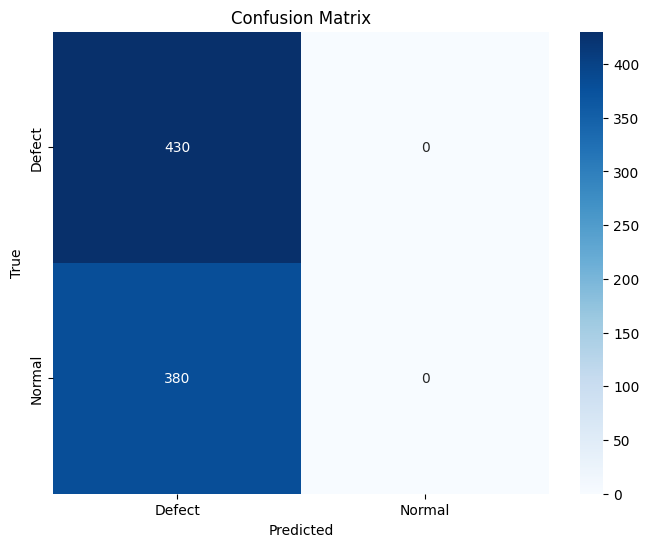

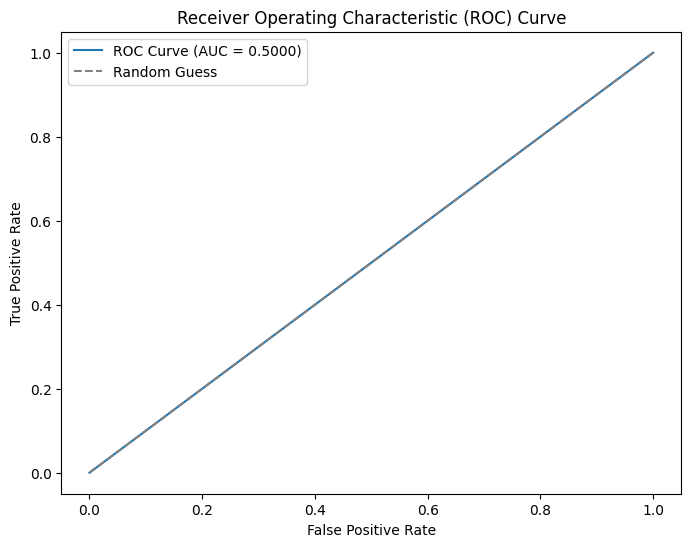

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import seaborn as sns

# Evaluate the model on test data
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_probs = []  # Store probabilities
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.numpy()  # Move labels to CPU for evaluation
            outputs = model(images).squeeze().cpu().numpy()  # Get probabilities
            preds = (outputs > 0.5).astype(int)  # Threshold for binary classification

            all_labels.extend(labels)
            all_probs.extend(outputs)  # Store probabilities
            all_preds.extend(preds)

    # Calculate metrics
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)  # Use probabilities for ROC
    roc_auc = auc(fpr, tpr)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {roc_auc:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Defect', 'Normal'], yticklabels=['Defect', 'Normal'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# Evaluate the model
evaluate_model(model, test_loader, device)


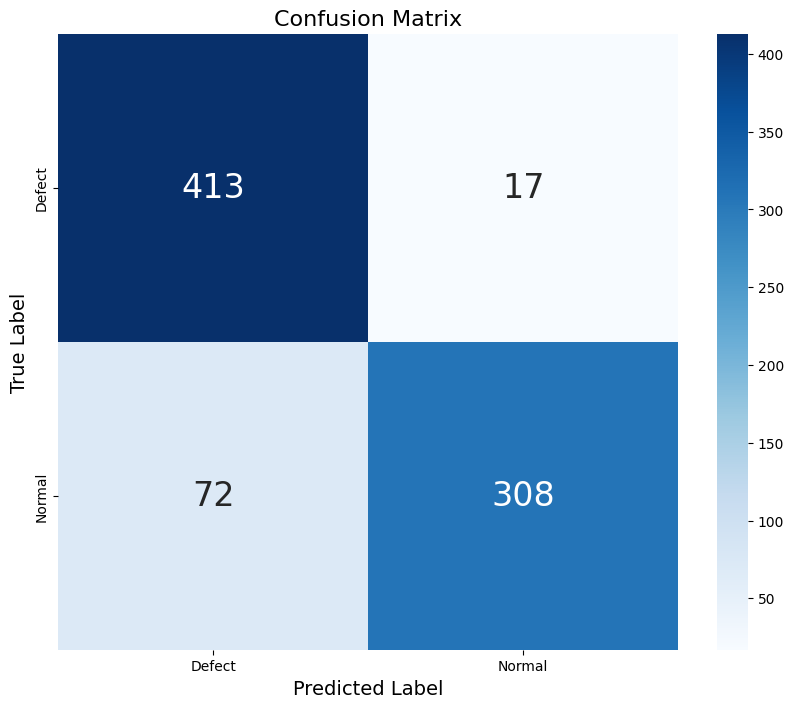

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 혼동행렬 데이터
confusion_matrix = np.array([[413, 17], [72, 308]])

# 클래스 레이블
class_labels = ['Defect', 'Normal']

# 그래프 생성
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 24}, # 숫자 크기 조정
            xticklabels=class_labels, yticklabels=class_labels)

# 축 레이블 설정
plt.ylabel('True Label', fontsize=14) # y축 레이블 크기 조정
plt.xlabel('Predicted Label', fontsize=14) # x축 레이블 크기 조정
plt.title('Confusion Matrix', fontsize=16) # 제목 크기 조정

# 그래프 보이기
plt.show()
